# Applied Statistics Final Project
## by Jenifer Vivar
## Instructor: Miodrag C Iovanov

<hr>

`The next couple of blocks collect and split the data into two parts, the trainig data for the model and the testing data`

<hr>

In [1]:
import struct
import gzip
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# create dictionaries to store the data
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import seaborn as sns
import statsmodels.api as sm
from sklearn import metrics
from sklearn.linear_model import Ridge
from yellowbrick.regressor import ResidualsPlot
import pylab as py

In [2]:
train = dict()
test = dict()

In [3]:
def get_images(filename) :
    with gzip.GzipFile(Path('mnist', filename), 'rb') as f:
        magic, size, rows, cols = struct.unpack(">IIII", f.read(16))
        print(magic, size, rows, cols)
        images = np.frombuffer(f.read(), dtype=np.dtype('B'))
    return images.reshape (size, rows, cols)

In [4]:
train['image'] = get_images('train-images-idx3-ubyte.gz')
test['image'] = get_images('t10k-images-idx3-ubyte.gz')
print(train['image'].shape, test['image'].shape)

2051 60000 28 28
2051 10000 28 28
(60000, 28, 28) (10000, 28, 28)


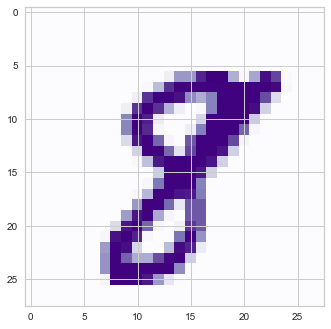

In [5]:
fig , ax = plt.subplots()
ax.imshow(train['image'][55], cmap = 'Purples')

In [6]:
def get_labels(filename) :
    with gzip.GzipFile(Path('mnist', filename), 'rb') as f:
        magic, num = struct.unpack(">II", f.read( 8 ))
        labels = np.frombuffer(f.read(), dtype=np.dtype('B'))
    return labels

In [7]:
train['label'] = get_labels('train-labels-idx1-ubyte.gz')
test['label'] = get_labels('t10k-labels-idx1-ubyte.gz')
print(train['label'].shape, test['label'].shape)

(60000,) (10000,)


In [8]:
#check that labels are between expected values
np.unique(train['label'])

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [9]:
print(train['image'].shape, train['label'].shape)

(60000, 28, 28) (60000,)


## Computation

<hr>

**With a binary classfier we seek to find a line that splits the plane into two. These line seeks to discriminate the input into either -1 or 1. In this case our images are the input and the binary classifier will decide if the input should be in the -1 or +1 category. Below is define the function $G(x)$ which takes as input the vector X, a weight vector $\beta $ and a bias $\beta_0$ :**

$G(X) = $
  \begin{cases} 
    1       & \quad\ X^{T}\beta + \beta_0 >= 0\\
    -1  & \quad\ X^{T}\beta + \beta_0 < 0
  \end{cases}

**The line for the decision boundary will then be:**
$ Y(x) = \beta_0 + \sum_{i=1}^{n} \beta_i x_i $

**so if we solve for $\beta_{0}$:**

$
\beta_{0} = Y - X^{T}\beta
$
<hr>


In [10]:
#adds ones to the x matrix
def oneD_bias_img(image):
    #create a zero array and makes images 1D
    flat = np.zeros((image.shape[0], np.product(image.shape[1:])))
    for i in range(flat.shape[0]):
        flat[i] = image[i].flatten()
    #adds a column of 1's to prevent bias for i.i.d r.v.
    unbias_array = np.concatenate([flat, np.ones((flat.shape[0], 1))], axis=1)
    return unbias_array
    

<hr>

**We now calculate the sum of squares using the method of least squares. We would like to find the weights of vector $\beta$ that minimizes the sum of squared errors as shown below:**

$E = ||Y - x\beta||^{2} = (Y - X_{i}^{T}\beta)^{2}$

**Because I want to find the minimum values I take the partial differential with respect to $\beta$ of the sum of squares formula, which is the error E (also known as $RSS = (Y - X_{i}^{T}\beta)^{2}$) and set it equal to 0**

$\frac{\partial E}{\partial \beta} = 2X^{T}(Y - X\beta) = 0$ 

**solving for $\beta$ we have:**
$
\beta = (X^T X)^{-1}X^TY 
$
**below beta is define**

<hr>

In [11]:
#classifier to determine if an image is k
def Beta(x, y):
    x_dot_x = np.matmul(x.T, x)
    b = np.matmul(np.linalg.pinv(x_dot_x), np.matmul(x.T,y))
    return b

So now that I have the value for $\beta$ I can solve for $\beta_{0}$:
$
\beta_{0} = Y - X^{T}\beta
$

In [12]:
def Beta_0(Y, X, beta):
    return np.array(Y - X@beta)

In [13]:
#converts the already known labels for test purposes
def y_hat(array, k):
    y_ = list(map(lambda num: 1 if num == k else -1, array))
    return y_

In [14]:
#transform the return values from x*beta into binary -1 and 1
def G(x, beta, beta_0):
    result = x@beta + beta_0.mean()
    predict = [1 if i >= 0 else -1 for i in result]
    return predict

<hr>

**Below is the first example of the classifier. I'm plugging in the known Y values just so that I can plot the 
$\beta$ and see what the weigthed values for the number k = 8 would look like.**
<hr>

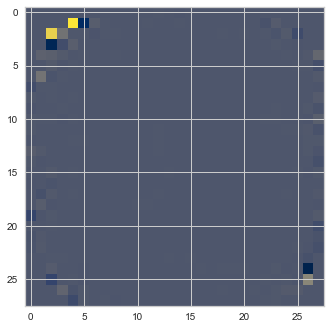

In [15]:
#Using train data for k = 8:
#x_unbias = oneD_bias_img(train['image'])
x_train = oneD_bias_img(train['image'])
y_train = y_hat(train['label'], 8)
beta = Beta(x_train, y_train)
plt.imshow(beta[:784].reshape(28,28), cmap = "cividis")
plt.show()

<hr>

**just out of curuiosity I plotted the range of values in the 28 pixels from the $\beta$ image. Closer to the origin we see mostly positive values (G(X) > = 0) which  means our k value was predicted. Any negative values mean the value was likely not our k number. Most of the result values are really small, around 0.**
<hr>

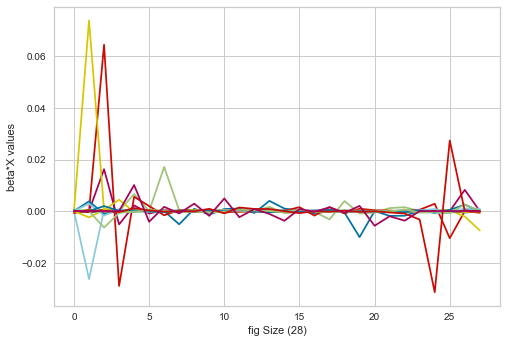

In [16]:
#distribution of values for the 28 pixels each picture has
plt.plot(beta[:784].reshape(28,28))
plt.xlabel("fig Size (28)")
plt.ylabel("beta*X values")
plt.show()

<hr>

**Now I'm trying to use my test data to see if my classifier is doing a good job. Because my classifier $\beta$ used k = 8 to be trained I will also be using k = 8 in this case.**
<hr>

In [17]:
beta_0 = Beta_0(y_train, x_train, beta)
print((beta_0))

[ 0.2594672   0.07767469  0.0459793  ... -0.40390608  0.43744862
  1.12714838]


In [18]:
#beta knot from train data:
beta_0 = Beta_0(y_train, x_train, beta)
#beta_0 = beta_0[:784].reshape(28,28)

#to test my classifier
x_test = oneD_bias_img(test['image'])
y_test = y_hat(test['label'], 8)

#gets the dot product of X and beta and classiffies it as either 1 or -1
y_pred = G(x_test, beta, beta_0)

<hr>

**Now I would like to know how good, or bad, my classifier is doing. For this I will define an error function since I will be using it a lot:**

In [19]:
def Error(y, x, beta):
    return (np.linalg.norm(y - x@beta))**2

In [20]:
error = Error(y_test, x_test, beta)
print(f"The minimum residual sum of suquares is: {error} \n",
f"The normalized RSS is: {error/len(y_test)}")

The minimum residual sum of suquares is: 1936.801130131852 
 The normalized RSS is: 0.1936801130131852


**The  value of the residual sum of squares is small when normalized. Ideally we would like this value to be as closer to 0 as possible but .2 is not bad. No I would like to know the actual number of 8's in the data set, that is how many my classifier recognized.**

In [21]:
#counting 1's in my array
actual_num = y_train.count(1)
pred_num = y_pred.count(1)
print(f"Actual number of 8's: {actual_num}\n",
f"predicted 8's in classifier: {pred_num} \n",
f"difference: {actual_num - pred_num}")

Actual number of 8's: 5851
 predicted 8's in classifier: 544 
 difference: 5307


[[8986   40]
 [ 470  504]]


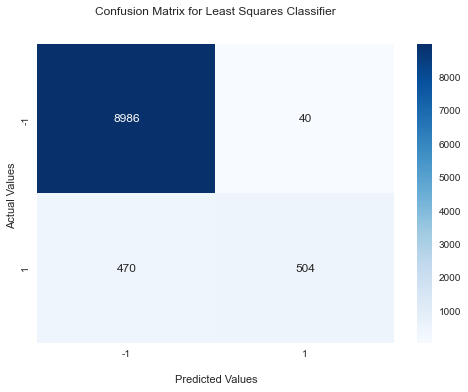

In [22]:
#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)
ax = sns.heatmap(cf_matrix, annot=True, fmt = 'd', cmap='Blues')

ax.set_title('Confusion Matrix for Least Squares Classifier\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['-1','1'])
ax.yaxis.set_ticklabels(['-1','1'])

## Display the visualization of the Confusion Matrix.
plt.show()

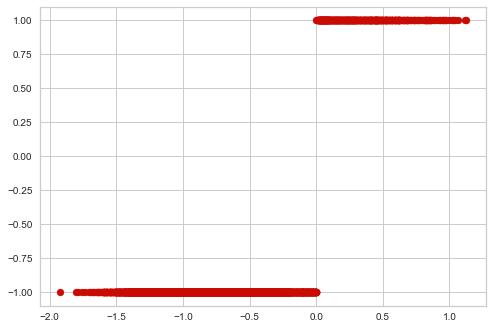

In [23]:
#below we see that the majority of values are not classified as k = 8 or +1
plt.scatter(x_test@beta, y_pred, c = 'r')
plt.show()

/Users/jenifervivar/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

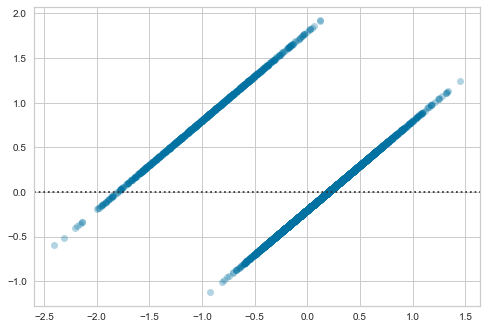

In [24]:
respo=  x_test@beta
sns.residplot(respo - y_test, y_test, scatter_kws={'alpha': 0.3},\
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

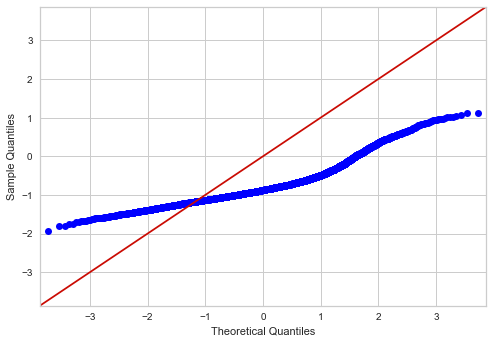

In [25]:
#(x_unbias_t@beta_
sm.qqplot(x_test@beta, line ='45')
py.show()

## Repeating for all sets of digits

--------------------------------------------
The test error is: 1041.3878909491723
The normalized error is: 0.10413878909491722
This means the error is about 10%
The error for the training set is 0.10144473393900147 or about 10%
Recall = 0.8836734693877552
Precision: 0.9526952695269527
Accuracy: 0.8619173262972736
-------------------------------------------
image to be input    found beta        input x beta,   confusion matrix


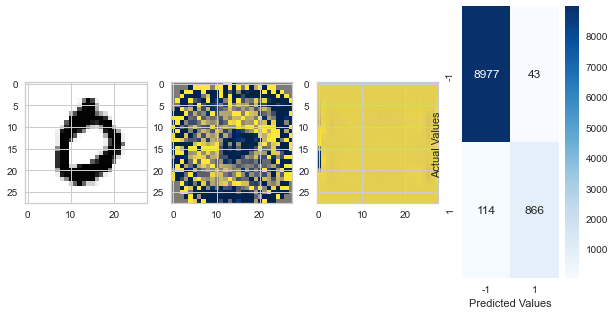

QQ-plot


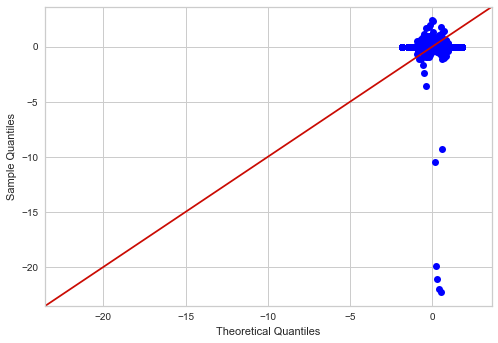

-------------------------------------------
--------------------------------------------
The test error is: 1145.3044222943654
The normalized error is: 0.11453044222943654
This means the error is about 11%
The error for the training set is 0.12024923363670448 or about 12%
Recall = 0.9118942731277533
Precision: 0.9400544959128065
Accuracy: 0.8724058416602614
-------------------------------------------
image to be input    found beta        input x beta,   confusion matrix


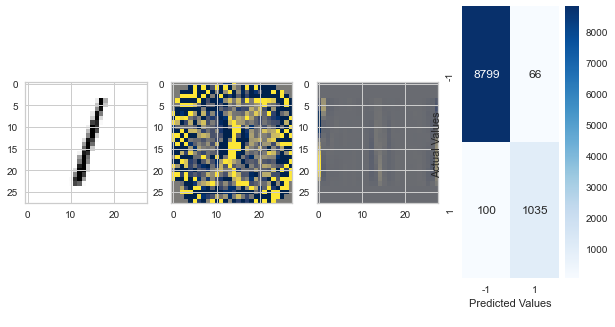

QQ-plot


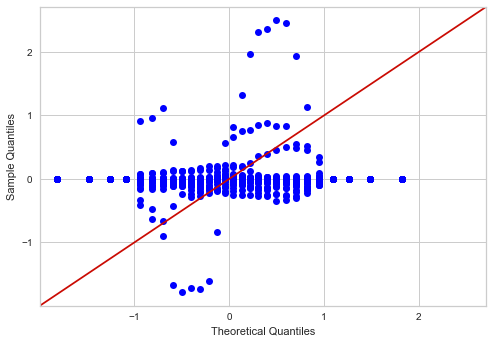

-------------------------------------------
--------------------------------------------
The test error is: 1547.1946298734142
The normalized error is: 0.15471946298734143
This means the error is about 15%
The error for the training set is 0.14804471351720955 or about 15%
Recall = 0.624031007751938
Precision: 0.9583333333333334
Accuracy: 0.712707182320442
-------------------------------------------
image to be input    found beta        input x beta,   confusion matrix


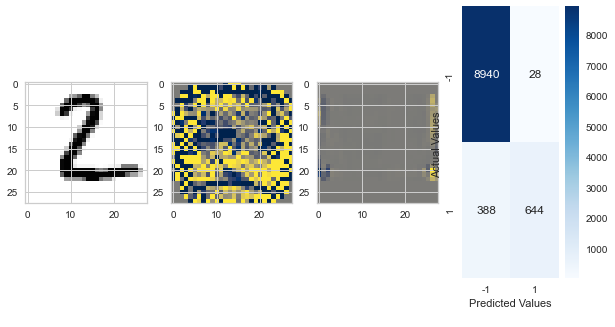

QQ-plot


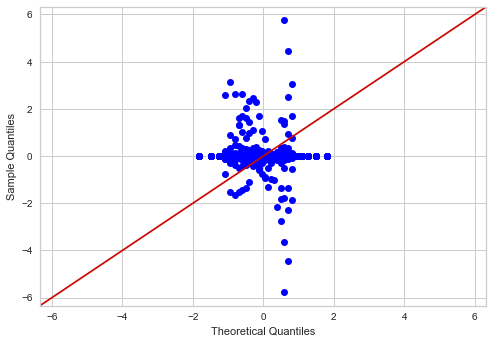

-------------------------------------------
--------------------------------------------
The test error is: 1714.4452466437824
The normalized error is: 0.17144452466437823
This means the error is about 17%
The error for the training set is 0.17422608409216808 or about 17%
Recall = 0.6485148514851485
Precision: 0.9383954154727794
Accuracy: 0.7173295454545454
-------------------------------------------
image to be input    found beta        input x beta,   confusion matrix


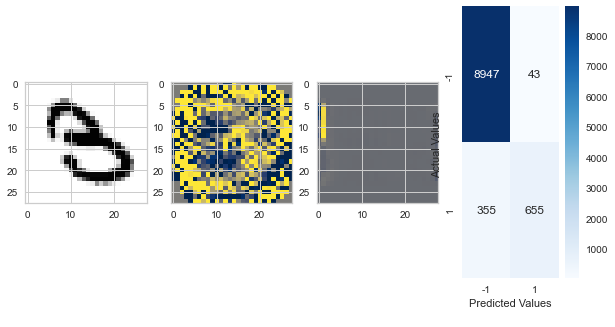

QQ-plot


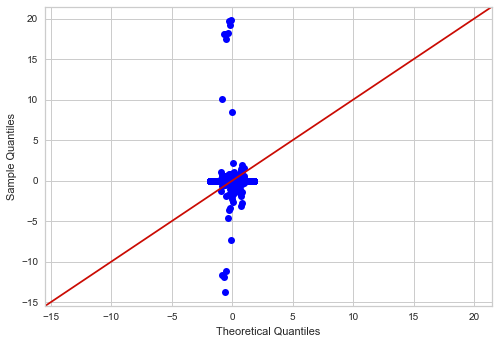

-------------------------------------------
--------------------------------------------
The test error is: 1642.9183014383952
The normalized error is: 0.16429183014383952
This means the error is about 16%
The error for the training set is 0.15982003133460015 or about 16%
Recall = 0.6975560081466395
Precision: 0.9474412171507607
Accuracy: 0.7456340167046317
-------------------------------------------
image to be input    found beta        input x beta,   confusion matrix


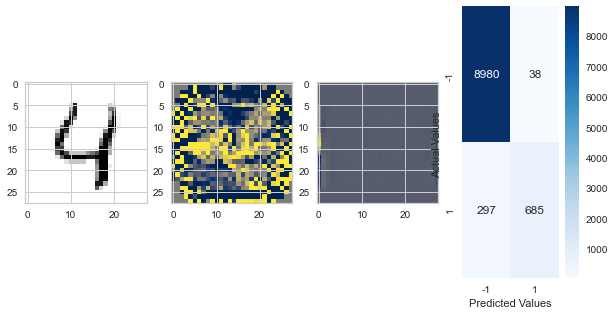

QQ-plot


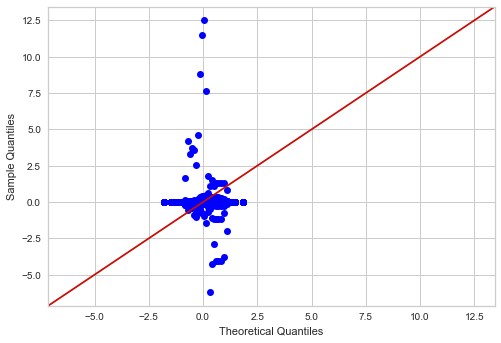

-------------------------------------------
--------------------------------------------
The test error is: 1822.48110984195
The normalized error is: 0.182248110984195
This means the error is about 18%
The error for the training set is 0.18347883008713642 or about 18%
Recall = 0.4618834080717489
Precision: 0.8803418803418803
Accuracy: 0.6246498599439776
-------------------------------------------
image to be input    found beta        input x beta,   confusion matrix


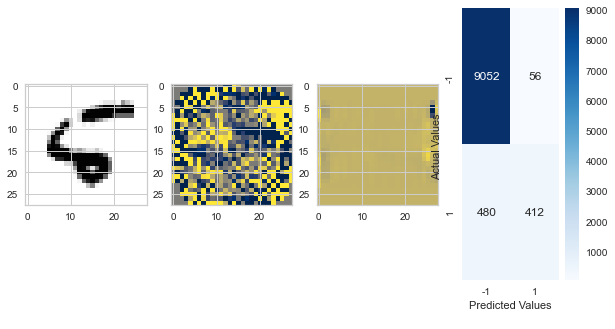

QQ-plot


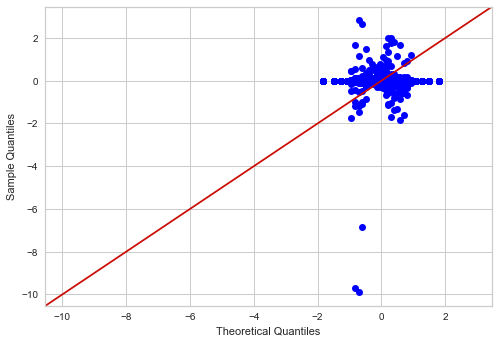

-------------------------------------------
--------------------------------------------
The test error is: 1115.8420123056078
The normalized error is: 0.11158420123056077
This means the error is about 11%
The error for the training set is 0.10526635441859782 or about 11%
Recall = 0.8058455114822547
Precision: 0.9125295508274232
Accuracy: 0.7865353037766831
-------------------------------------------
image to be input    found beta        input x beta,   confusion matrix


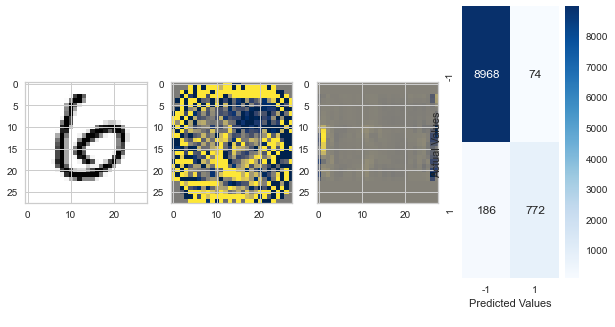

QQ-plot


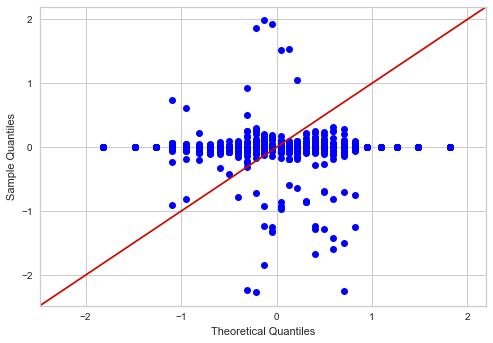

-------------------------------------------
--------------------------------------------
The test error is: 1402.5155743709588
The normalized error is: 0.1402515574370959
This means the error is about 14%
The error for the training set is 0.13578044124038657 or about 14%
Recall = 0.7149805447470817
Precision: 0.9233668341708543
Accuracy: 0.743849493487699
-------------------------------------------
image to be input    found beta        input x beta,   confusion matrix


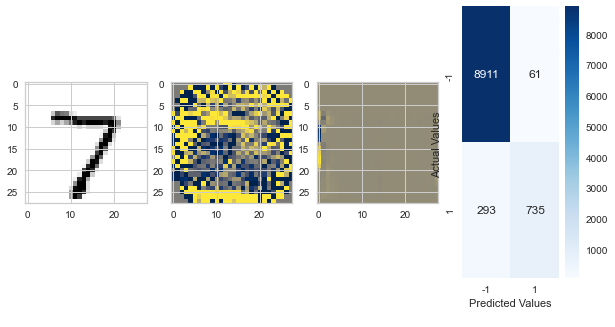

QQ-plot


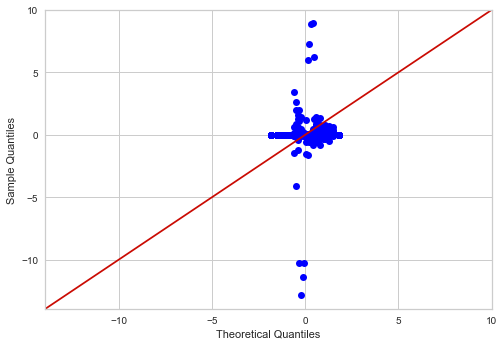

-------------------------------------------
--------------------------------------------
The test error is: 1936.801130131852
The normalized error is: 0.1936801130131852
This means the error is about 19%
The error for the training set is 0.19322700840958854 or about 19%
Recall = 0.5174537987679672
Precision: 0.9264705882352942
Accuracy: 0.6563342318059299
-------------------------------------------
image to be input    found beta        input x beta,   confusion matrix


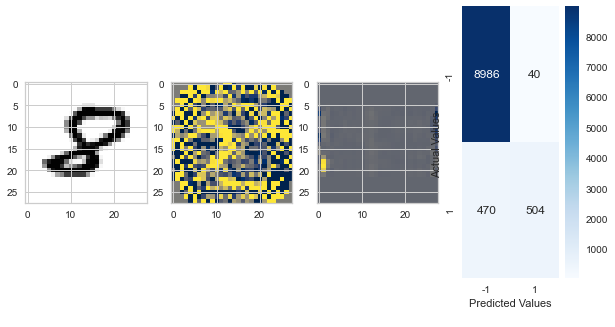

QQ-plot


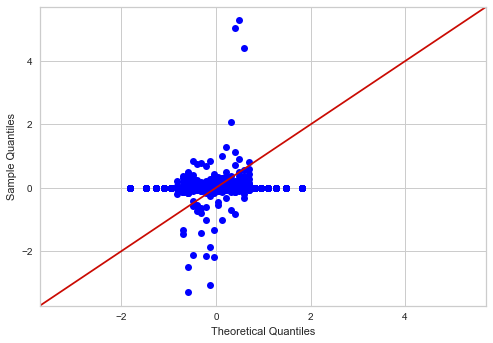

-------------------------------------------
--------------------------------------------
The test error is: 1983.2316520538172
The normalized error is: 0.19832316520538174
This means the error is about 20%
The error for the training set is 0.19853772093757174 or about 20%
Recall = 0.5550049554013875
Precision: 0.8874801901743264
Accuracy: 0.6599084368868542
-------------------------------------------
image to be input    found beta        input x beta,   confusion matrix


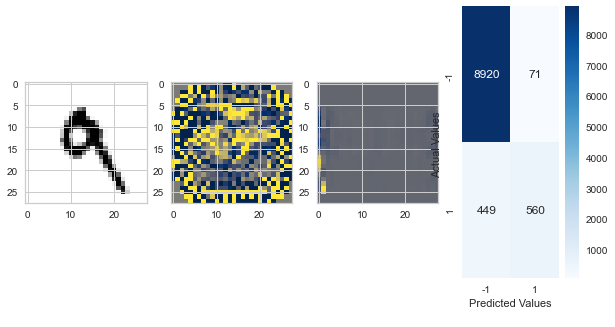

QQ-plot


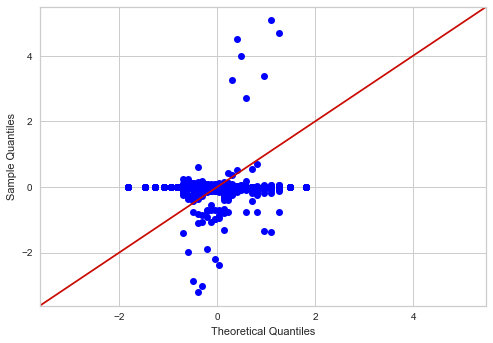

-------------------------------------------
Below are the error for the Train and Test data respectally in a triangula matrix
[[1041.38789095    0.            0.            0.            0.
     0.            0.            0.            0.            0.        ]
 [1041.38789095 1145.30442229    0.            0.            0.
     0.            0.            0.            0.            0.        ]
 [1041.38789095 1145.30442229 1547.19462987    0.            0.
     0.            0.            0.            0.            0.        ]
 [1041.38789095 1145.30442229 1547.19462987 1714.44524664    0.
     0.            0.            0.            0.            0.        ]
 [1041.38789095 1145.30442229 1547.19462987 1714.44524664 1642.91830144
     0.            0.            0.            0.            0.        ]
 [1041.38789095 1145.30442229 1547.19462987 1714.44524664 1642.91830144
  1822.48110984    0.            0.            0.            0.        ]
 [1041.38789095 1145.30442229 1547.1

In [26]:
#applying same steps to all images
errorTest = []
errorTrain = []
for t in range(0,10):
    x_train = oneD_bias_img(train['image'])
    y_train = y_hat(train['label'], t)
    
    beta  = Beta(x_train,y_train)
    beta_0 = Beta_0(y_train, x_train, beta)
    
    x_test = oneD_bias_img(test['image'])
    y_test = y_hat(test['label'], t)
    
    y_pred = G(x_test, beta, beta_0)
    
    cf_matrix = confusion_matrix(y_test, y_pred)
    
    #count the total of 1's in each list
    """
    actual_num = y_test.count(1)
    pred_num = y_pred.count(1)
    print(f"Actual number of {t}'s: {actual_num}, ",
    f"predicted {t}'s in classifier: {pred_num}, ",
    f"difference: {actual_num - pred_num}")
    """
    #print(np.dot(x_test[np.where(y==1)[0][0]][:784].T , beta_[:784].squeeze()))
    print("--------------------------------------------")
    error = Error(y_test, x_test, beta)
    errorTest.append(error)
    error_train = Error(y_train, x_train, beta)
    errorTrain.append(error_train)
    print(f"The test error is: {error}")
    print(f"The normalized error is: {error/len(y_test)}")
    print(f"This means the error is about {round(error/len(y_test)*100)}%")
    print(f"The error for the training set is {error_train/len(y_train)} or about {round((error_train/len(y_train))*100)}%")
    print(f"Recall = {cf_matrix[1][1]/(cf_matrix[1][1] + cf_matrix[1][0])}")
    print(f"Precision: {cf_matrix[1][1]/(cf_matrix[1][1]+ cf_matrix[0][1])}")
    print(f"Accuracy: {(cf_matrix[1][1] + cf_matrix[1][0])/(cf_matrix[1][1]+ cf_matrix[1][0]+cf_matrix[0][1] + cf_matrix[1][0])}")
    print("-------------------------------------------")
    
    print("image to be input    found beta        input x beta,   confusion matrix")
    beta= (beta[:784].reshape(28,28))
    
 
    fig, axes = plt.subplots(1, 4, figsize=(10, 5))
    
    ax = axes[0]
    ax.imshow(x_test[np.where(test['label']==t)][0][:784].reshape(28,28))
    
    """np.where searches for the index where the label is the number t. The [0] indicates I only need one element 
    of the many that apply to plot. The [:784]gets rid of the last row of ones I added to I can re-shape it.
    """
    scale = 8
    ax = axes[1]
    ax.imshow(beta,vmin=-0.001/scale, vmax=0.001/scale, cmap = 'cividis')
   
    ax = axes[2]
    ax.imshow(x_test[np.where(test['label']==t)][0][:784].reshape(28,28)@beta, cmap = 'cividis')
    

    ax = axes[3]
    ax = sns.heatmap(cf_matrix, annot=True, fmt = 'd', cmap='Blues')
    ax.set_xlabel('Predicted Values\n')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['-1','1'])
    ax.yaxis.set_ticklabels(['-1','1'])
    
    plt.show()
    
    print("QQ-plot")
    ax = sm.qqplot(x_test[np.where(test['label']==t)][0][:784].reshape(28,28)@beta, line ='45')
    py.show()
    print("-------------------------------------------")
    
print("Below are the error for the Train and Test data respectally in a triangula matrix")
errorTrain = np.triu(errorTrain)
errorTest = np.tril(errorTest)
print(errorTest)
print(errorTrain)

**The numbers where the classifier did relatively bad are the numbers 5, 8, and, 9. Most of their accuracy are about 65%. Its vissible why this is from the $\beta$ plots of each. The image lacks the basic shape of the number for the most part. This might be due to the circular shape they have and how this looks closer to the value 0.** 

## 2 using logistic Regression:

In [27]:
def confusing_plot(con_matrix, name = None):
    ax = sns.heatmap(cf_matrix, annot=True, fmt = 'd', cmap='Blues')
    ax.set_xlabel('Predicted Values\n')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['-1','1'])
    ax.yaxis.set_ticklabels(['-1','1'])
    
    if name != None:
        plt.savefig(name)
    plt.show()

Number: 0
Accuracy: 0.9917
Precision: 0.9534883720930233
Recall: 0.9622448979591837
-------------------------------------------


/Users/jenifervivar/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


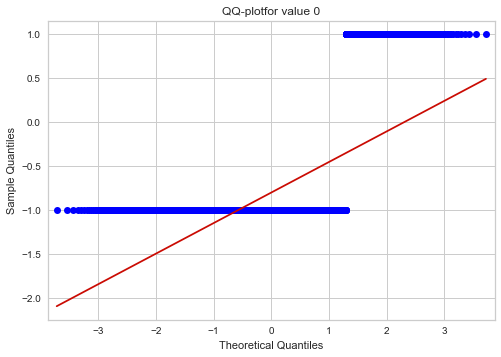

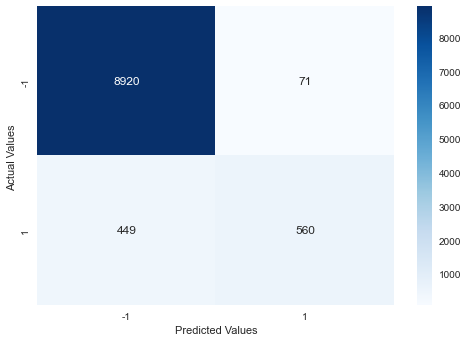

Number: 1
Accuracy: 0.9931
Precision: 0.9675438596491228
Recall: 0.9718061674008811
-------------------------------------------


/Users/jenifervivar/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


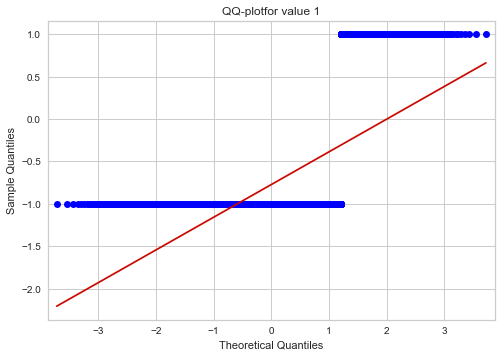

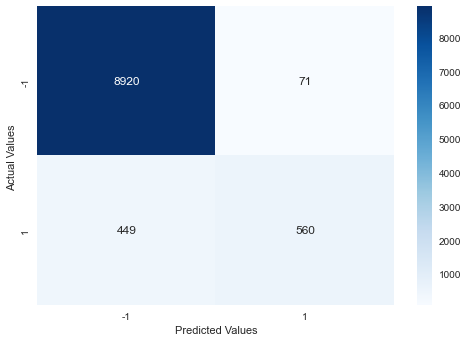

Number: 2
Accuracy: 0.9798
Precision: 0.9540481400437637
Recall: 0.8449612403100775
-------------------------------------------


/Users/jenifervivar/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


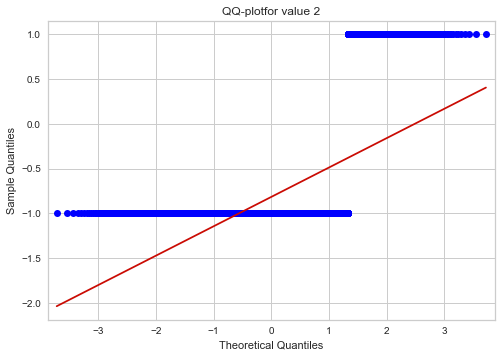

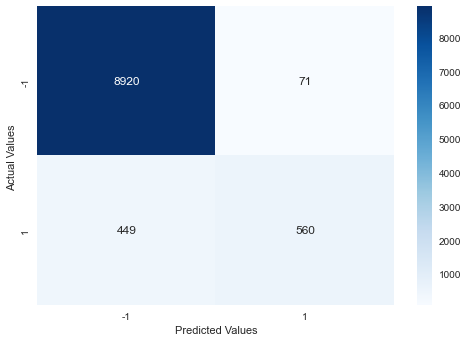

Number: 3
Accuracy: 0.9768
Precision: 0.9138297872340425
Recall: 0.8504950495049505
-------------------------------------------


/Users/jenifervivar/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


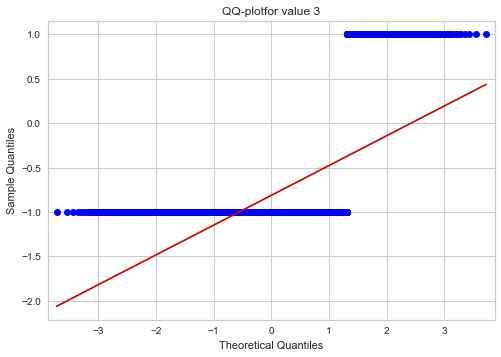

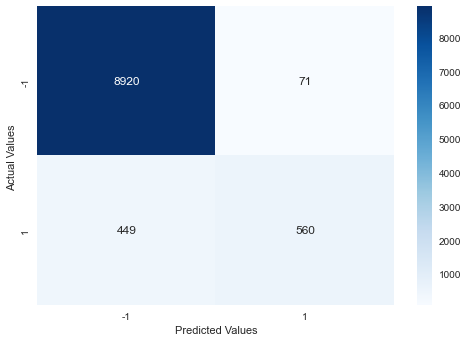

Number: 4
Accuracy: 0.9822
Precision: 0.9222689075630253
Recall: 0.8940936863543788
-------------------------------------------


/Users/jenifervivar/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


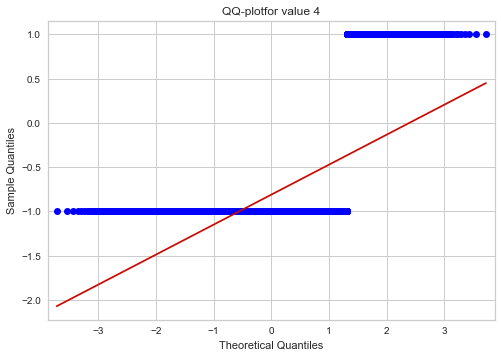

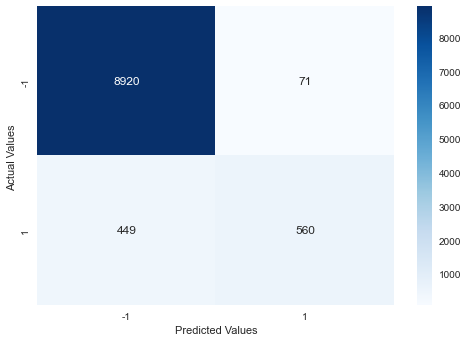

Number: 5
Accuracy: 0.977
Precision: 0.9106699751861043
Recall: 0.8228699551569507
-------------------------------------------


/Users/jenifervivar/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


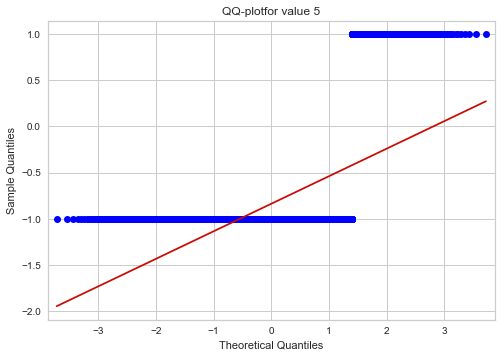

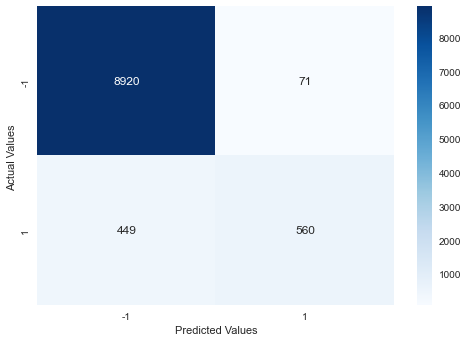

Number: 6
Accuracy: 0.9859
Precision: 0.9368983957219251
Recall: 0.9144050104384134
-------------------------------------------


/Users/jenifervivar/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


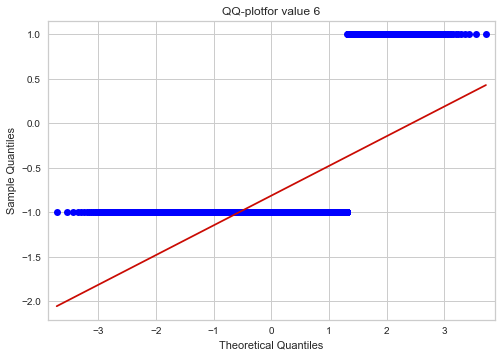

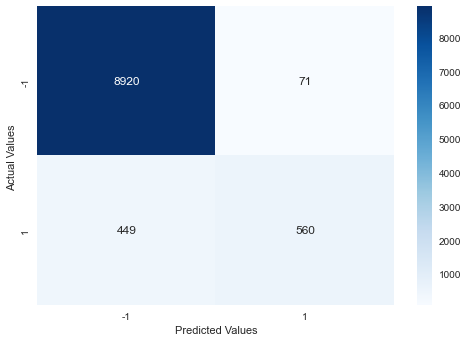

Number: 7
Accuracy: 0.9826
Precision: 0.9313131313131313
Recall: 0.896887159533074
-------------------------------------------


/Users/jenifervivar/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


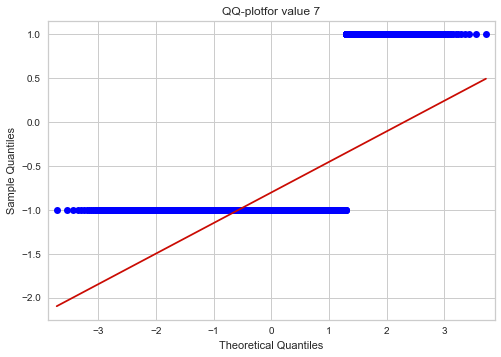

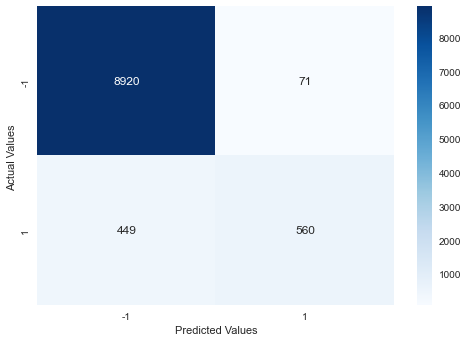

Number: 8
Accuracy: 0.9617
Precision: 0.8472385428907168
Recall: 0.7402464065708418
-------------------------------------------


/Users/jenifervivar/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


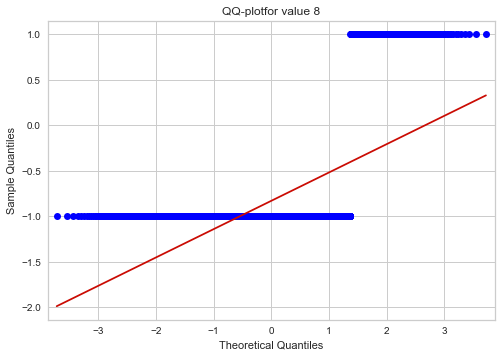

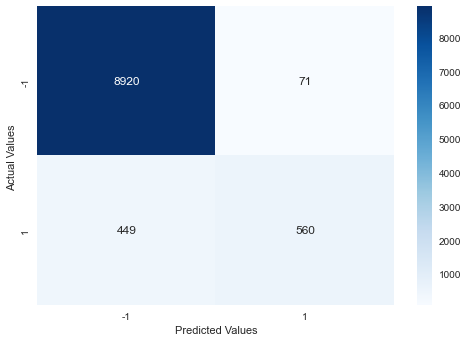

Number: 9
Accuracy: 0.9664
Precision: 0.8591248665955176
Recall: 0.7978196233894945
-------------------------------------------


/Users/jenifervivar/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


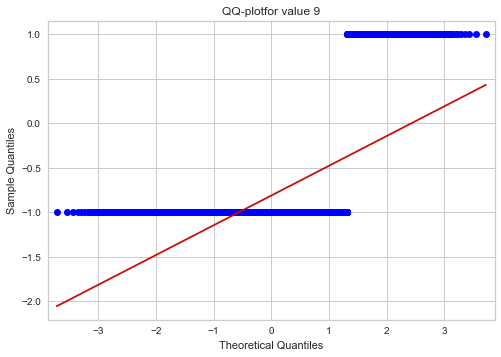

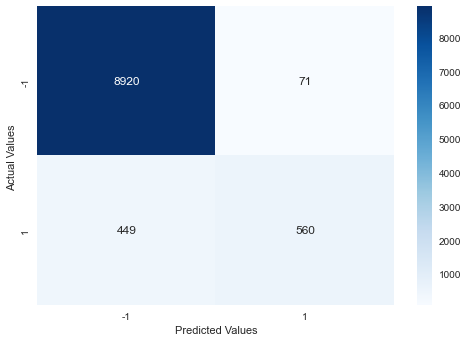

In [28]:
for t in range(0,10):
    x_train = oneD_bias_img(train['image'])
    y_train = y_hat(train['label'], t)
    beta  = Beta(x_train, y_train)
    
    y_test = y_hat(test['label'], t)
    x_test = oneD_bias_img(test['image'])
    
    #transformm data from to standar scaler and then fits it to a logistic regression function.
    #It uses an interation of 200
    pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter = 200,  solver ='sag'))
    pipe.fit(x_train, y_train)
    
    #predicting the unseen values from the data set
    y_pred = pipe.predict(x_test)
    
    #prints the metrics of the classifier for each of the y preducted values from the test
    print(f"Number: {t}")
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("Precision:",metrics.precision_score(y_test, y_pred))
    print("Recall:",metrics.recall_score(y_test, y_pred))
    print("-------------------------------------------")
    #this will plot the qq plot to determine if the values are normally distributed
    sm.qqplot(y_pred, line ='r')
    plt.title(f"QQ-plotfor value {t}")
    plt.show()
    
    #plots the confusion matrix from the function above
    confusion_matrixx = confusion_matrix(y_pred, y_test)
    confusing_plot(confusion_matrixx)

<hr>
<hr>

**Overall the Least Squares classifier perform decently butt the logistic classifier perform better. For the trouble numbers 5, 8, and, 9 the accuracy range was close to 75% using logistic regression and above the one obtained for the humble least squares classifier. Still, the algorithm discrimated images with their respective values above 65% of the time.** 
